<a href="https://colab.research.google.com/github/Taehee-K/2021-DataCreator/blob/main/final/kobert_title.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.chdir('/content/gdrive/MyDrive/잠자리/데이터크리에이터/본선')

In [41]:
# SKTKobert 설치
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [4]:
import warnings
warnings.filterwarnings(action='ignore')

In [42]:
!pip install transformers==3
!pip install gluonnlp tqdm
!pip install sentencepiece
!pip install mxnet

In [6]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

In [7]:
from transformers import AdamW 
from transformers.optimization import get_cosine_schedule_with_warmup

In [8]:
import re
import sys
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import gluonnlp as nlp
from tqdm import tqdm, tqdm_notebook
from transformers import BertTokenizer, BertModel

In [9]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print('Pytorch version: ', torch.__version__)
print('DEVICE: ', DEVICE)

Pytorch version:  1.9.0+cu111
DEVICE:  cuda


In [11]:
bertmodel, vocab = get_pytorch_kobert_model()

[██████████████████████████████████████████████████]
[██████████████████████████████████████████████████]


In [12]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model


# Load Data

In [13]:
df = pd.read_csv('./train.csv')
df

,category,char_count,title,abstractive
0,2,923,재해 없는 안전사업장 만들겠습니다,"[""기아자동차 광주공장은 12일 원하청 공생 협력을 통한 6대 핵심 안전수칙 준수와..."
1,0,1336,"군공항 피해 보상, 기다릴 수만은 없다","[""군용 비행장에서 발생하는 전투기 소음 등 피해에 대한 해결책과 보상 문제 등을 ..."
2,3,923,"위워크, BIFC서 2호점...금융·스타트업 시너지 기대",['글로벌 사무실 공유기업 위워크(WeWork)는 지난 1일 국내 20번째 지점으로...
3,1,854,모바일로 모든 금융계좌 한 번에 조회...26일부터 증권계좌도 서비스,['금감원은 은행에 이어 26일부터 22개 증권사를 대상으로 계좌통합관리서비스를 ...
4,1,1366,"SKB, 5기가 전송 솔루션 개발...최고 5Gbps 가능","[""SK브로드밴드가 UTP 랜케이블망에서도 사용자에게 상하향 동시 최대 5Gbps ..."
...,...,...,...,...
26995,3,921,"지하철 9호선 3단계, 송파·강동구 이용객 일평균 2.8만명↑",['서울지하철 9호선 3단계 개통이후 송파·강동구의 지하철 이용자 수가 일평균 2만...
26996,1,815,"교원더오름, 티 브랜드 ‘메디프레소’ 론칭","[""교원그룹은 몸에 좋은 차를 간편하게 즐길 수 있도록 만든 캡슐 티 브랜드 '메디..."
26997,1,1479,"헬로네이처, 친환경 배송 서비스 '더그린배송' 전면 확대","[""헬로네이처는 다시 사용할 수 있는 배송상자 더그린박스와 자연 친화적인 성분으로 ..."
26998,5,1116,文대통령 “연내 ‘인공지능 국가전략’ 제시”,"[""문재인 대통령은 28일 소프트웨어·인공지능 분야 콘퍼런스에서, 국내 인공지능 기..."


In [14]:
df2 = pd.read_csv('./test.csv')
df2

,Unnamed: 0,char_count,title,abstractive
0,0,1097,"""충북도, 항공정비 유치단 구성해야""",['정의당 김종대 국회의원은 4일 청주공항에 저비용항공사와 F-35스텔스 전투기가 ...
1,1,1121,헌재 '박영수 특검법' 합헌...최순실 헌법소원 기각,"[""헌재는 28일 최씨가 제기한, 대통령이 특검 후보자 2명을 당시 여당인 새누리당..."
2,2,758,2019년도 하반기 강서시장 리더 포럼 개최,['서울시농수산식품공사 강서지사는 16일 도매시장 현안과 유통 및 농업환경 변화 공...
3,3,895,"‘2년 연속 1부 생존’ 대구FC, K리그1 잔류 조기 확정","[""대구는 4일 오후 2시 대구스타디움에서 열린 'KEB 하나은행 K리그1 2018..."
4,4,778,"한화생명, '스마트플랜 종합보장보험' 출시","[""8일 한화생명은 예고없이 찾아오는 사고 대비 위한 보장을 담은 '스마트플랜 종합..."
...,...,...,...,...
3295,3295,846,익산시 신청사 북부권 이전 주장 '논란',['익산지역 일부 시민들이 시청사를 북부권으로 이전 주장을 하고 있으나 시청사 이전...
3296,3296,768,"성남중원경찰서, 범죄피해자 지원 나선다",['성남중원경찰서는 19일 경찰서 회의실에서 범죄피해자들의 신속한 피해회복 및 보호...
3297,3297,1625,"괴물투, 별들마저 잠재웠다",['KBO리그에서 메이저리그 진출 7시즌 만에 올스타에 뽑힌 류현진은 10일 오하이...
3298,3298,1425,"인터넷가입 사은품 많이 주는 곳, 인터넷비교사이트 ‘당현함’ 현금지원 당일지급으로 ...",['인터넷가입을 알아보는 소비자 수가 늘어나면서 인터넷가입 비교사이트가 각광받고 있...


## Train, Validation, Test

In [15]:
data = df.copy()
data = data[["title", 'category']]

train = data.sample(frac = 0.7, random_state = 42)
val = data.loc[~data.index.isin(train.index)]

test = df2.copy()
test = test.rename(columns={"Unnamed: 0": 'category'})
test = test[["title", 'category']]

display(train, val, test)

,title,category
5312,"‘박카스’ 동아제약, 충남 당진에 생산 공장 건립",3
18357,부산항 해양산업클러스터 활성화 속도 낸다,3
6428,"양육비 안 주는 前배우자, 본인 동의 없이도 주소·직장 조회가능",3
15414,청주시 창업동아리 경진대회 성료,2
10610,프랑스프로축구연맹 “황의조 팬 마음 사로잡을 것”,4
...,...,...
14621,"제네시스, 내년 6종 풀라인업 완성...""1년 앞당겨 유럽·중국 도전장""",1
15332,"강경화 ""日과의 신뢰문제로 내린 결정...한미동맹은 별개로 공조 강화""",1
7329,국산 의약품 베트남 수출확대 청신호,2
10200,"전문적, 독보적인 시스템으로 독서와 글쓰기 관리",3


,title,category
1,"군공항 피해 보상, 기다릴 수만은 없다",0
9,"김서영, 수영 국대 선발전 1위로 광주행",4
11,KIA 선수단 핑크 유니폼 입는다,4
13,"유재석·김용만, 대법원서 6억 출연료 미지급 소송 승소",0
16,"윤병용 전남우슈협회장, 세계선수권 한국대표팀 부단장 선임",4
...,...,...
26982,"전직 의원 24명, 취업제한기관에 취업 승인",0
26988,중소벤처기업 청년·장병 채용박람회,2
26989,광주로 돌아온 양향자···빨라진 총선 시계,5
26996,"교원더오름, 티 브랜드 ‘메디프레소’ 론칭",1


,title,category
0,"""충북도, 항공정비 유치단 구성해야""",0
1,헌재 '박영수 특검법' 합헌...최순실 헌법소원 기각,1
2,2019년도 하반기 강서시장 리더 포럼 개최,2
3,"‘2년 연속 1부 생존’ 대구FC, K리그1 잔류 조기 확정",3
4,"한화생명, '스마트플랜 종합보장보험' 출시",4
...,...,...
3295,익산시 신청사 북부권 이전 주장 '논란',3295
3296,"성남중원경찰서, 범죄피해자 지원 나선다",3296
3297,"괴물투, 별들마저 잠재웠다",3297
3298,"인터넷가입 사은품 많이 주는 곳, 인터넷비교사이트 ‘당현함’ 현금지원 당일지급으로 ...",3298


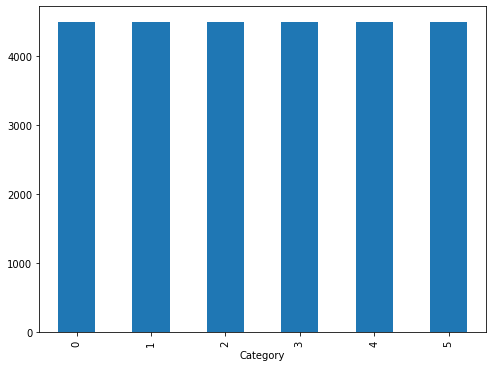

In [16]:
# 정치, 경제, 사회, 문화, 스포츠, IT/과학
fig = plt.figure(figsize=(8,6))
data.groupby('category').title.count().plot.bar(ylim=0)
plt.xlabel('Category')
plt.show()

# 모든 클래스가 균등하게 분포되어 있는 것을 알 수 있다

In [17]:
from collections import Counter
Counter(data['category'])

Counter({0: 4500, 1: 4500, 2: 4500, 3: 4500, 4: 4500, 5: 4500})

# Train Model

## Encode Data

In [18]:
# 버트 인코더
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [19]:
## Setting parameters
max_len = 50
batch_size = 32
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  0.5e-5

In [20]:
data_train = BERTDataset(train.values, 0, 1, tok, max_len, True, False)
data_val = BERTDataset(val.values, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(test.values, 0, 1, tok, max_len, True, False)

In [21]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
val_dataloader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

## BERT Classifier

In [22]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=6, # 6 classes
                 dr_rate=0.2,   # dropout > overfitting 방지
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [23]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(DEVICE)

## Train

In [24]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [25]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [26]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [27]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [28]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [32]:
best_acc = 0.0

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(DEVICE)
        segment_ids = segment_ids.long().to(DEVICE)
        valid_length= valid_length
        label = label.long().to(DEVICE)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):
        token_ids = token_ids.long().to(DEVICE)
        segment_ids = segment_ids.long().to(DEVICE)
        valid_length= valid_length
        label = label.long().to(DEVICE)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

    # 모델 저장하기
    if (test_acc / (batch_id+1)) > best_acc:
      torch.save(model, f'model/kobert_{test_acc / (batch_id+1)}.pt')
      print(f'Save Best Model: model/kobert_{test_acc / (batch_id+1)}.pt')

  0%|          | 0/591 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.0629708766937256 train acc 0.59375
epoch 1 batch id 201 loss 1.0113261938095093 train acc 0.6595149253731343
epoch 1 batch id 401 loss 0.8189958930015564 train acc 0.6606140897755611
epoch 1 train acc 0.6599830795262267


  0%|          | 0/254 [00:00<?, ?it/s]

epoch 1 test acc 0.6323818897637795
Save Best Model: model/kobert_0.6323818897637795.pt


  0%|          | 0/591 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.9751094579696655 train acc 0.65625
epoch 2 batch id 201 loss 0.9075921773910522 train acc 0.6850124378109452
epoch 2 batch id 401 loss 0.902641773223877 train acc 0.6853958852867831
epoch 2 train acc 0.6869712351945855


  0%|          | 0/254 [00:00<?, ?it/s]

epoch 2 test acc 0.639886811023622
Save Best Model: model/kobert_0.639886811023622.pt


  0%|          | 0/591 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 1.0298457145690918 train acc 0.625
epoch 3 batch id 201 loss 0.9052298069000244 train acc 0.7117537313432836
epoch 3 batch id 401 loss 0.7915560007095337 train acc 0.7092425187032418
epoch 3 train acc 0.7084073604060913


  0%|          | 0/254 [00:00<?, ?it/s]

epoch 3 test acc 0.640871062992126
Save Best Model: model/kobert_0.640871062992126.pt


  0%|          | 0/591 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 1.0011379718780518 train acc 0.625
epoch 4 batch id 201 loss 0.7960056662559509 train acc 0.7251243781094527
epoch 4 batch id 401 loss 0.7399744987487793 train acc 0.7249064837905237
epoch 4 train acc 0.7241434010152284


  0%|          | 0/254 [00:00<?, ?it/s]

epoch 4 test acc 0.6428395669291339
Save Best Model: model/kobert_0.6428395669291339.pt


  0%|          | 0/591 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.9737522006034851 train acc 0.6875
epoch 5 batch id 201 loss 0.7709542512893677 train acc 0.7470460199004975
epoch 5 batch id 401 loss 0.5839977264404297 train acc 0.7411159600997507
epoch 5 train acc 0.7379230118443316


  0%|          | 0/254 [00:00<?, ?it/s]

epoch 5 test acc 0.6435777559055118
Save Best Model: model/kobert_0.6435777559055118.pt


  0%|          | 0/591 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.9403899908065796 train acc 0.71875
epoch 6 batch id 201 loss 0.6873530149459839 train acc 0.7504664179104478
epoch 6 batch id 401 loss 0.61118483543396 train acc 0.7468827930174564
epoch 6 train acc 0.7453680203045685


  0%|          | 0/254 [00:00<?, ?it/s]

epoch 6 test acc 0.6459153543307087
Save Best Model: model/kobert_0.6459153543307087.pt


  0%|          | 0/591 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.9445400238037109 train acc 0.75
epoch 7 batch id 201 loss 0.7589676380157471 train acc 0.7504664179104478
epoch 7 batch id 401 loss 0.6331047415733337 train acc 0.7507793017456359
epoch 7 train acc 0.7475148054145516


  0%|          | 0/254 [00:00<?, ?it/s]

epoch 7 test acc 0.6465305118110236
Save Best Model: model/kobert_0.6465305118110236.pt


  0%|          | 0/591 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.8119508028030396 train acc 0.71875
epoch 8 batch id 201 loss 0.6370359063148499 train acc 0.7552860696517413
epoch 8 batch id 401 loss 0.6435993909835815 train acc 0.7537406483790524
epoch 8 train acc 0.750105752961083


  0%|          | 0/254 [00:00<?, ?it/s]

epoch 8 test acc 0.6461614173228346
Save Best Model: model/kobert_0.6461614173228346.pt


  0%|          | 0/591 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.9255837798118591 train acc 0.75
epoch 9 batch id 201 loss 0.6921760439872742 train acc 0.7582400497512438
epoch 9 batch id 401 loss 0.6661011576652527 train acc 0.7521041147132169
epoch 9 train acc 0.7494500846023688


  0%|          | 0/254 [00:00<?, ?it/s]

epoch 9 test acc 0.6467765748031497
Save Best Model: model/kobert_0.6467765748031497.pt


  0%|          | 0/591 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.9478622078895569 train acc 0.65625
epoch 10 batch id 201 loss 0.6935833096504211 train acc 0.7524875621890548
epoch 10 batch id 401 loss 0.649433970451355 train acc 0.75
epoch 10 train acc 0.7472081218274113


  0%|          | 0/254 [00:00<?, ?it/s]

epoch 10 test acc 0.6435777559055118
Save Best Model: model/kobert_0.6435777559055118.pt


# Evaluate Model

In [34]:
# 모델 불러오기
saved = torch.load('model/kobert_0.6467765748031497.pt')
saved.eval()

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

In [35]:
# Confusion Matrix, 각 class 별 Accuracy 출력

nb_classes = 6

def Analyze(model, test_loader):
  test_acc = 0.0  # test accuracy

  # prediction, label list 초기화
  predlist=torch.zeros(0,dtype=torch.long, device='cpu')
  lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

  with torch.no_grad(): 
      for i, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_loader)):
        token_ids = token_ids.long().to(DEVICE)
        segment_ids = segment_ids.long().to(DEVICE)
        valid_length= valid_length
        label = label.to(DEVICE)                                # 라벨 값 DEVICE에 할당
        outputs = model(token_ids, valid_length, segment_ids)   # 예측
        _, preds = torch.max(outputs, 1)                        # 가장 높은 확률 가지는 class 예측
        test_acc += calc_accuracy(outputs, label)

        # Batch 단위 예측값 append 하기
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,label.view(-1).cpu()])

  # Print Accuracy
  print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

  # Classification Report
  print(classification_report(lbllist.numpy(), predlist.numpy())) # 클래스별 accuracy, recall, f1-score 
  
  return predlist # Class 별 Accuracy 담은 dataframe 반환

In [36]:
class_acc = Analyze(saved, val_dataloader)

  0%|          | 0/254 [00:00<?, ?it/s]

epoch 10 test acc 0.6467765748031497
              precision    recall  f1-score   support

           0       0.49      0.35      0.41      1329
           1       0.65      0.71      0.68      1343
           2       0.56      0.62      0.59      1373
           3       0.60      0.63      0.62      1328
           4       0.92      0.87      0.89      1363
           5       0.64      0.70      0.66      1364

    accuracy                           0.65      8100
   macro avg       0.64      0.65      0.64      8100
weighted avg       0.64      0.65      0.64      8100



# Submit Result

In [37]:
nb_classes = 6
def prediction(model, test_loader):

  # prediction, label list 초기화
  predlist=torch.zeros(0,dtype=torch.long, device='cpu')

  with torch.no_grad(): 
      for i, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_loader)):
        token_ids = token_ids.long().to(DEVICE)
        segment_ids = segment_ids.long().to(DEVICE)
        valid_length= valid_length
        label = label.to(DEVICE)                                # 라벨 값 DEVICE에 할당
        outputs = model(token_ids, valid_length, segment_ids)   # 예측
        _, preds = torch.max(outputs, 1)                        # 가장 높은 확률 가지는 class 예측

        # Batch 단위 예측값 append 하기
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
  return predlist

In [38]:
result = prediction(saved, test_dataloader)

  0%|          | 0/104 [00:00<?, ?it/s]

In [39]:
len(result)

3300

In [40]:
# y_test = model.predict(X_test)

submission_df=pd.DataFrame(result,columns=["category"])
submission_df.index.name="index"
submission_df.to_csv("submission_kobert_title.csv",index=True)
submission_df

,category
index,
0,5
1,3
2,3
3,4
4,1
...,...
3295,5
3296,3
3297,4
